# Naive Bayes example

2023-12-24 by @jpgil

This notebook is available in Google Colaboratory at https://colab.research.google.com/github/paranal-sw/parlogs-observations/blob/main/notebooks/03-error-based-analysis.ipynb

Based on the previous notebook of simple error analysis, let's train Naive Bayes predictor. For a more detailed explanation of Naive Bayes please refer to https://www.datacamp.com/tutorial/naive-bayes-scikit-learn

## Imports and Dataset

In [1]:
import os
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    precision_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)


# Set the warning mode to 'None' to suppress the warning SettingWithCopyWarning
pd.options.mode.chained_assignment = None

### Load Dataset

In [2]:
from urllib.request import urlretrieve
def direct_load(fname):
    if not os.path.exists(f'{PATH}/{fname}'):
        urlretrieve(f'{REPO_URL}/{fname}', f'{PATH}/{fname}')
    df=pd.read_parquet(f'{PATH}/{fname}')
    return df


In [3]:
INSTRUMENT='GRAVITY'
RANGE='1m'
REPO_URL='https://huggingface.co/datasets/Paranal/parlogs-observations/resolve/main/data'
PATH='sample_data' # Convenient name to be Colab compatible

!mkdir -p $PATH

df_meta = direct_load(f'{INSTRUMENT}-{RANGE}-meta.parket')
df_inst = direct_load(f'{INSTRUMENT}-{RANGE}-traces.parket')
df_subs = direct_load(f'{INSTRUMENT}-{RANGE}-traces-SUBSYSTEMS.parket')
df_tele = direct_load(f'{INSTRUMENT}-{RANGE}-traces-TELESCOPES.parket')

## Overview

Each trace will be labeled by the state of its parent execution state. For example, if an failed observation execution generated 100 event traces, all those traces will be marked as "Failed".

Next, for each trace we will concatenate all

## Prepare the dataset

In [4]:
# Feature extraction 

def extract_errcode(x):
    return x.split()[0] if 'ERR_' in x else '' 

def extract_errdata(x):
    # Given the nature of error logs, the majority uses the pattern .+ERR_.+, but other important ERR logs must be used as is.
    if 'ERR_' in x:
        errdata=' '.join(x.split()[2:])
        return re.sub(r'[^a-zA-Z\ ]', ' ', errdata)
    else:
        return ''


In [5]:
# Merge the datasets
df_all = pd.concat([df_inst, df_subs, df_tele]).sort_values('@timestamp').reset_index(drop=True)
print(f'There all {len(df_all)} total traces')

# All the traces are merged and filtered by ERR only
df_all = df_all[ df_all['logtype']=='ERR']
print(f'After filtering, there are {len(df_all)} ERR traces')

# Extract features
df_all['errcode'] = df_all['logtext'].apply( extract_errcode )
df_all['errdata'] = df_all['logtext'].apply( extract_errdata )

print(f'{len(df_all[ df_all["errcode"]=="" ])} empty errcodes about to be discarded of  {len(df_all)} events in trace')

df_all = df_all[ df_all["errcode"]!="" ]


There all 3541706 total traces
After filtering, there are 848633 ERR traces
215 empty errcodes about to be discarded of  848633 events in trace


In [6]:
# Split in success, failed
df_meta_success = df_meta[ df_meta['ERROR']==False ]
df_meta_success['STATE'] = 'Success'

df_meta_failed  = df_meta[ df_meta['ERROR']==True ]
df_meta_failed['STATE']  = 'Failed'

print(f'Of all executions, {len(df_meta_failed)} failed and {len(df_meta_success)} were successful')

Of all executions, 92 failed and 676 were successful


### One Hot Encoding

## Train Test Split

In [7]:
# Train Test factor
FACTOR=0.66

# 1. Split the executions, in df_meta_*

# Randomize
df_meta_success=df_meta_success.sample(frac=1)
df_meta_failed =df_meta_failed.sample(frac=1)

len_S_train = int( len(df_meta_success) * FACTOR )
len_F_train = int( len(df_meta_failed) * FACTOR )

# Up to len_*_train
X_meta_train = pd.concat([df_meta_success[:len_S_train], df_meta_failed[:len_F_train]])

len_S_test = len(df_meta_success) - len_S_train
len_F_test = len(df_meta_failed) - len_F_train

# From len_*_test until end
X_meta_test  = pd.concat([df_meta_success[-len_S_test:],  df_meta_failed[-len_F_test:]])

print(f'Train ({len_S_train}+{len_F_train}) + Test ({len_S_test}+{len_F_test}) = {len_S_train+len_F_train+len_S_test+len_F_test} / {len(df_meta)}')



Train (446+60) + Test (230+32) = 768 / 768


In [8]:
# 2. Collect traces for each execution type

y_train = X_meta_train['STATE'].to_list()
y_test  = X_meta_test['STATE'].to_list()

In [9]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# 3. Vectorize the words

# Trace dataframe as inputs
# X_train[0] contains all traces for first execution of X_meta_train
X_train_errcodes = [ ' '.join(list(df_all[ df_all['trace_id'] == trace_id ]['errcode'])) for trace_id in X_meta_train.index  ]
X_test_errcodes  = [ ' '.join(list(df_all[ df_all['trace_id'] == trace_id ]['errcode'])) for trace_id in X_meta_test.index  ]

# display(X_test_errcodes)

# Using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_errcodes)
X_test = vectorizer.transform(X_test_errcodes)

print(f'X_train={X_train.shape[0]}, X_test={X_test.shape[0]}, y_train={len(y_train)}, y_test={len(y_test)}')


X_train=506, X_test=262, y_train=506, y_test=262


Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

      Failed       0.38      0.38      0.38        32
     Success       0.91      0.91      0.91       230

    accuracy                           0.85       262
   macro avg       0.64      0.64      0.64       262
weighted avg       0.85      0.85      0.85       262



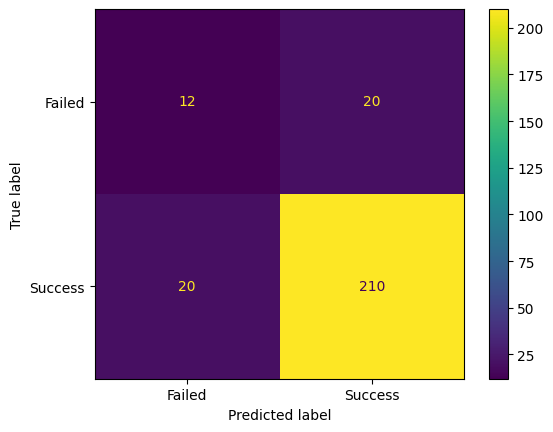

In [10]:

classifier = MultinomialNB()

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_rep)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Failed', 'Success'])
disp.plot();

